# Import variants VCF file

In [1]:
import numpy as np
import pandas as pd
import allel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
vcf = allel.read_vcf("../data/raw/1349 sample and all 253k unfiltered SNPs.vcf", )

In [3]:
variants = np.char.array(vcf["variants/CHROM"].astype(str)) + ":" + np.char.array(vcf["variants/POS"].astype(str))

In [4]:
vcf_arr = vcf["calldata/GT"].astype("float")
vcf_arr[vcf_arr == -1] = np.nan

In [5]:
mutations = vcf_arr
# mutations = np.abs(mutations)
mutations = mutations.sum(axis=2)
mutations = mutations.T
mutations.shape

(1349, 253708)

In [6]:
mutations_df = pd.DataFrame(data=mutations, index=vcf["samples"], columns=variants)
mutations_df.shape

(1349, 253708)

In [7]:
mutations_df.dropna(axis=1, how="any", thresh=800, inplace=True)
mutations_df.shape

(1349, 244975)

In [8]:
mutations_df.dropna(axis=0, how="any", thresh=200000, inplace=True)
mutations_df.fillna(value=0, inplace=True)

In [9]:
mutations_df.isna().sum().sum()

0

# Subset variants by gene

In [80]:
variants_top56_genes = pd.read_table("../data/interim/variants_top56_genes.csv", sep=",")
variants_top56_genes = variants_top56_genes.filter(items=["Gene(s)", "Variant ID"])

/Users/jonny/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
variants_top56_genes.set_index("Variant ID", inplace=True)

In [86]:
genes_matched_variants = mutations_df.columns & variants_top56_genes.index

In [87]:
mutations_gene_matched = mutations_df.T.join(variants_top56_genes, how="right")

In [88]:
mutations_gene_gb = mutations_gene_matched.groupby("Gene(s)")

In [89]:
mutations_by_gene = {}
for x in mutations_gene_gb.groups:
    mutations_gene_df = mutations_gene_gb.get_group(x)
    gene_name = mutations_gene_df["Gene(s)"].iloc[0]
    print(gene_name)
    mutations_gene_df = mutations_gene_df.drop(columns=["Gene(s)"]).dropna(axis=0).T
#     mutations_gene_df.to_csv("../data/processed/SNPs_by_gene/"+gene_name+".csv")
    mutations_by_gene[gene_name] = mutations_gene_df

BANK1
BIK
BLK
BTNL2
CDHR5
CEP70
CHD7
CNTNAP2
DAP
DAPK1
DSCAM
DSCAML1
ETS1
FAIM
GSDMB
HLA-DOB
HLA-DQA1
HLA-DQA2
HLA-DQB1
HLA-DQB2
HLA-DRA
HLA-DRB1
HLA-DRB5
ICA1
ICAM1
IKZF3
IRF5
IRF8
ITGAM
ITGAX
MECP2
NMNAT2
PHRF1
PRDM1
PXK
RAVER1
ROBO3
ROBO4
SCUBE1
SMG7
STAT4
TAP2
TLR7
TNFAIP3
TNFRSF13B
TNFSF4
TNIP1
TNPO3
TSPO
TTLL12
TYK2
UBE2L3
XKR6


# Gene - mutations

In [93]:
variant_genes = pd.read_table("../data/raw/216k Variants with gene name.csv", sep=",")
variant_genes

/Users/jonny/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Variant,Chromosome,Position,Reference,Alternate,Identifier,Classification,Priority,Gene(s),Transcripts(s),HGVS Description
0,1:173152297-SNV,1,173152297,G,C,NaN,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152297G>C
1,1:173152373-SNV,1,173152373,C,G,rs112986214,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152373C>G
2,1:173152374-Ins,1,173152374,-,AGAAAG,rs10644515,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152373_173152374insAGAAAG
3,1:173152442-SNV,1,173152442,C,T,NaN,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152442C>T
4,1:173152471-SNV,1,173152471,G,T,NaN,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152471G>T
...,...,...,...,...,...,...,...,...,...,...,...
216485,X:153387062-SNV,X,153387062,C,G,NaN,Intergenic,1,?,?,g.153387062C>G
216486,X:153387153-SNV,X,153387153,G,C,NaN,Intergenic,1,?,?,g.153387153G>C
216487,X:153387218-SNV,X,153387218,T,G,rs6655245,Intergenic,1,?,?,g.153387218T>G
216488,X:153387377-SNV,X,153387377,G,A,NaN,Intergenic,1,?,?,g.153387377G>A


# Run PCA

In [100]:
def get_top_k_components(snp_data, var_threshold=0.80, return_fit_transform=False):
    pca = PCA()
    pca.fit(snp_data)
    top_k = np.argmax(np.cumsum(pca.singular_values_) / np.sum(pca.singular_values_) > var_threshold)
    
    if return_fit_transform:
        return pca.transform(snp_data)[:, :top_k]
    else:
        return pca.components_[:top_k]

def get_top_variant_by_coef(pca_components, coef_percentile=70):
    gene_coefs_sum = np.abs(pca_components).sum(axis=0)
    coefs_percentile = np.percentile(gene_coefs_sum, coef_percentile)
    return np.where(gene_coefs_sum > coefs_percentile)

def select_top_variants(snp_data, var_threshold=0.80, coef_percentile=70):
    variants = snp_data.columns
    top_k_components = get_top_k_components(snp_data, var_threshold)
    top_variants_idx = get_top_variant_by_coef(top_k_components, coef_percentile)

    return variants[top_variants_idx]

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Variant coefficients from PCA top-k components feature selection for "+gene)
plt.ylabel("coefficient")
plt.xlabel("genes")
plt.scatter(x=range(pca.components_.shape[1]), y=gene_coefs_sum)

# Compute PCA projections of all SNP data

In [101]:
pca_projs_by_gene = {}
for gene in mutations_by_gene.keys():
    pca_projs_by_gene[gene] = get_top_k_components(mutations_by_gene[gene], 
                                                   var_threshold=0.80,
                                                   return_fit_transform=True)
    print(gene, mutations_by_gene[gene].shape[1],  pca_projs_by_gene[gene].shape)

BANK1 3961 (1167, 402)
BIK 522 (1167, 161)
BLK 2236 (1167, 327)
BTNL2 664 (1167, 77)
CDHR5 159 (1167, 56)
CEP70 474 (1167, 146)
CHD7 1740 (1167, 362)
CNTNAP2 1532 (1167, 296)
DAP 1597 (1167, 306)


ValueError: Found array with 0 feature(s) (shape=(1167, 0)) while a minimum of 1 is required.

<BarContainer object of 53 artists>

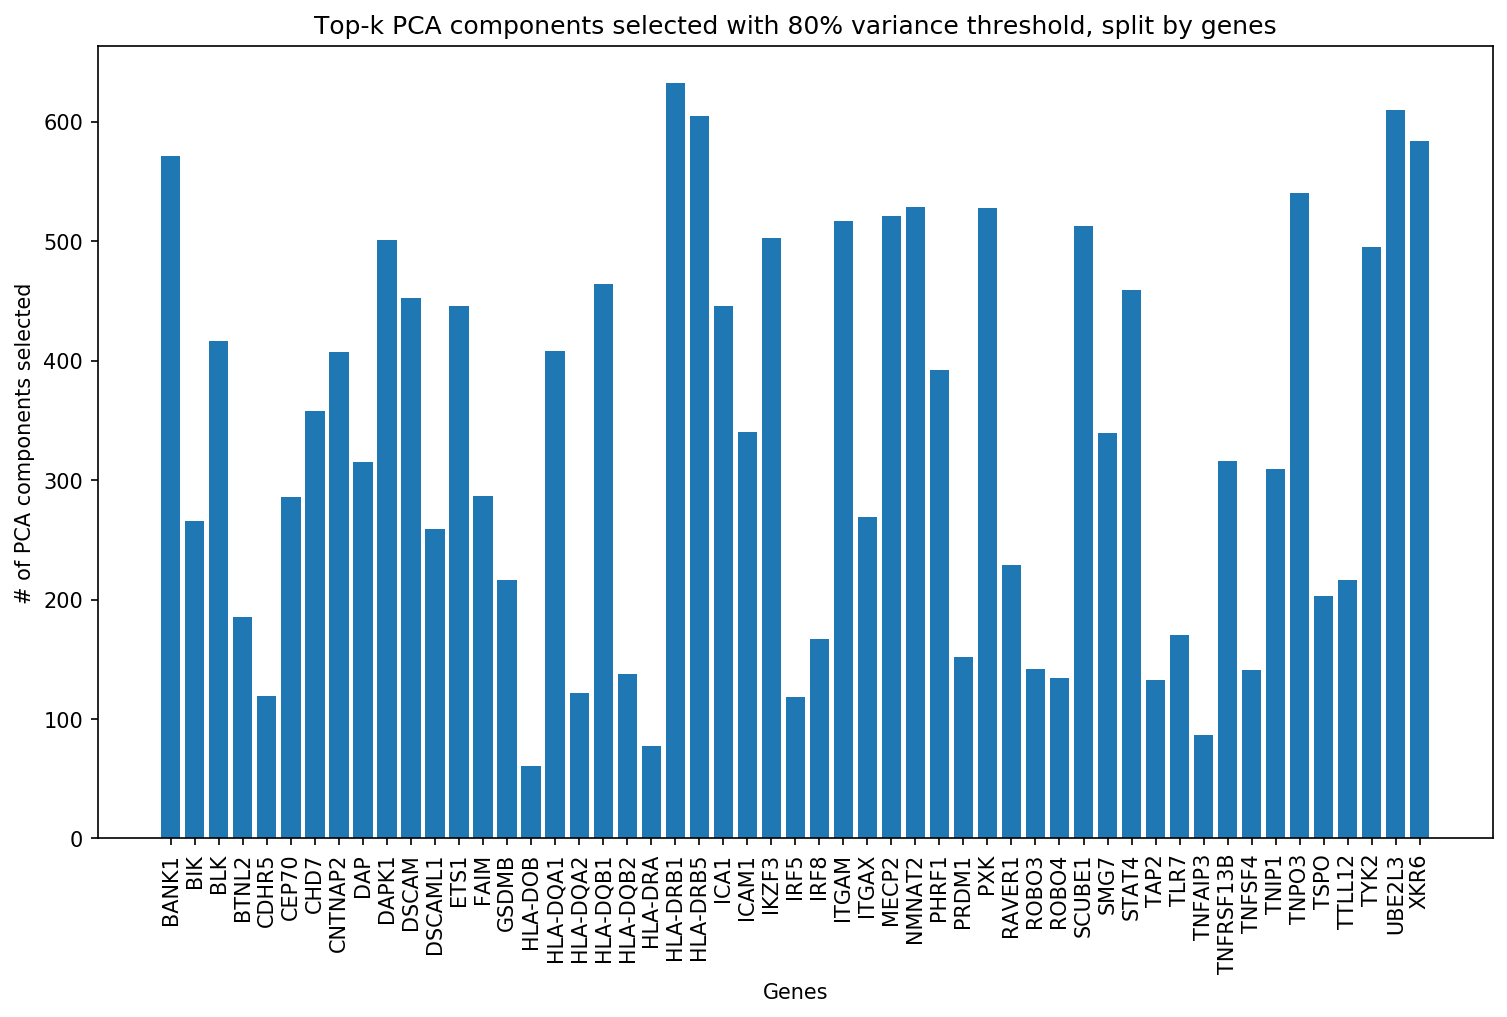

In [231]:
genes = list(pca_projs_by_gene.keys())
num_top_components = [pca_projs_by_gene[gene].shape[1] for gene in genes]
plt.figure(figsize=(12, 7), dpi=150)
plt.title("Top-k PCA components selected with 80% variance threshold, split by genes")
plt.xlabel("Genes")
plt.xticks(rotation=90)
plt.ylabel("# of PCA components selected")
plt.bar(x=genes, height=num_top_components)

In [208]:
# Concatenate all projections into one matrix
pca_projs_by_gene["STAT4"].shape

(1349, 459)

In [213]:
pca_projs_concat = np.concatenate([pca_projs_by_gene[gene] for gene in pca_projs_by_gene.keys()],
                                 axis=1)
pca_projs_concat.shape

(1349, 17693)

In [ ]:
pca_projs_concat_df = pd.DataFrame(pca_projs_concat, index=mutations_gene_df.index)
pca_projs_concat_df.T

In [217]:
pca_projs_concat_df.T.to_csv("../data/interim/PCA_projections_80_variance.csv")

# Select variants by percentile

In [172]:
top_variants_by_gene = {}
for gene in mutations_by_gene.keys():
    top_variants_by_gene[gene] = select_top_variants(mutations_by_gene[gene], var_threshold=0.80, coef_percentile=70)
    print(gene, mutations_by_gene[gene].shape[1],  top_variants_by_gene[gene].shape[0])

BANK1 6828 2049
BIK 911 273
BLK 2937 881
BTNL2 968 290
CDHR5 338 102
CEP70 972 292
CHD7 2429 729
CNTNAP2 2484 745
DAP 2011 603
DAPK1 6835 2051
DSCAM 3179 954
DSCAML1 998 300
ETS1 2889 867
FAIM 994 298
GSDMB 685 206
HLA-DOB 129 39
HLA-DQA1 1275 383
HLA-DQA2 492 148
HLA-DQB1 1578 474
HLA-DQB2 473 142
HLA-DRA 263 79
HLA-DRB1 3409 1023
HLA-DRB5 3760 1127
ICA1 4165 1250
ICAM1 1043 313
IKZF3 3781 1134
IRF5 397 119
IRF8 668 201
ITGAM 2982 895
ITGAX 1057 317
MECP2 2902 871
NMNAT2 5815 1745
PHRF1 1800 540
PRDM1 545 163
PXK 3989 1197
RAVER1 755 227
ROBO3 351 105
ROBO4 330 99
SCUBE1 4588 1377
SMG7 1941 582
STAT4 2755 827
TAP2 548 165
TLR7 597 179
TNFAIP3 305 92
TNFRSF13B 1214 364
TNFSF4 538 162
TNIP1 1628 489
TNPO3 4060 1218
TSPO 633 190
TTLL12 890 267
TYK2 2155 647
UBE2L3 4022 1207
XKR6 10417 3125


In [176]:
all_top_variants = []
for gene in top_variants_by_gene.keys():
    all_top_variants.extend(top_variants_by_gene[gene])
len(all_top_variants)

34122

# Concatenate all selected variant into one DataFrame

In [182]:
mutations_df = mutations_df.loc[:,~mutations_df.columns.duplicated()]

In [183]:
mutations_top_variants_df = mutations_df.filter(items=all_top_variants)

In [184]:
mutations_top_variants_df

,4:102711068,4:102712657,4:102713097,4:102713410,4:102713410,4:102713412,4:102713412,4:102713419,4:102713419,4:102713419,...,8:11058039,8:11058071,8:11058203,8:11058345,8:11058400,8:11058400,8:11058478,8:11058479,8:11058892,8:11058990
Betty_Ill_4901_2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,2,0
ucl223ILL1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
Betty_Ill_3822_2,0,1,0,0,0,1,1,0,0,0,...,0,2,0,0,0,0,0,0,2,0
CKG1996ILL1,0,2,1,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
Betty_Ill_5103_2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57739,0,0,0,0,0,0,0,0,0,0,...,0,2,2,2,2,2,2,2,2,2
1561,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
2546,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,2,2,2,2
686-1,0,1,1,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [185]:
mutations_top_variants_df.to_csv("../data/interim/mutations_top_variants_80_variance.csv")

# Graph the eigenvalues

In [109]:
import matplotlib.pyplot as plt

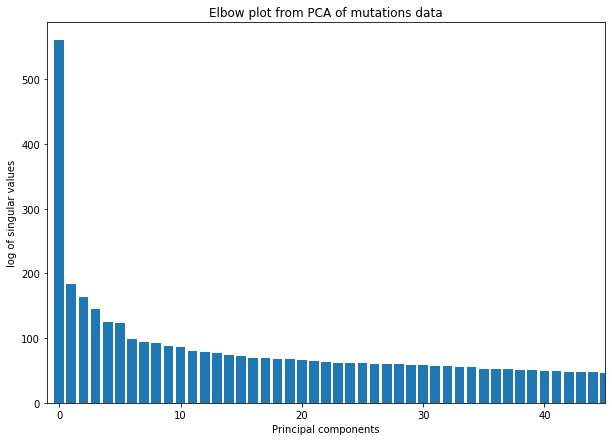

In [113]:
plt.figure(figsize=(10, 7))
plt.bar(x=range(pca.singular_values_.shape[0]), 
        height=pca.singular_values_, )

plt.ylabel('log of singular values')
plt.xlabel('Principal components')
plt.title('Elbow plot from PCA of mutations data')
plt.xlim(-1, 45)
# plt.ylim(0, 10)
plt.show()